In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO ---
np.random.seed(42)
n_samples = 2500
filter_order = 11  # 12 taps

# Entrada: Sinal com correlação moderada
x_w = (np.random.randn(n_samples) + 1j*np.random.randn(n_samples)) / np.sqrt(2)
x = np.convolve(x_w, [1, 0.5, 0.2], mode='same')

# Planta Desconhecida (Caminho de canal complexo)
w_true = np.exp(-0.2 * np.arange(filter_order + 1)) * (np.random.randn(filter_order + 1) + 1j*np.random.randn(filter_order + 1))

# Gerando o sinal desejado com ruído
noise_std = 0.03
d_clean = np.zeros(n_samples, dtype=complex)
for k in range(len(w_true), n_samples):
    reg = x[k : k - len(w_true) : -1]
    d_clean[k] = np.vdot(w_true, reg)

d = d_clean + noise_std * (np.random.randn(n_samples) + 1j*np.random.randn(n_samples))

# --- 2. EXECUÇÃO DO FILTRO SM-SIMP-AP ---
# L: Ordem de projeção (aqui usada para manter a estrutura de matriz)
# gamma_bar: Limite de erro aceitável
# gamma: Regularização
filt_simp_ap = pdf.SimplifiedSMAP(
    filter_order=filter_order,
    gamma_bar=0.07, 
    gamma=1e-3,
    L=3
)

result = filt_simp_ap.optimize(x, d, verbose=True, return_internal_states=True)

[SM-Simp-AP] Updates: 371/2500 | Runtime: 13.00 ms


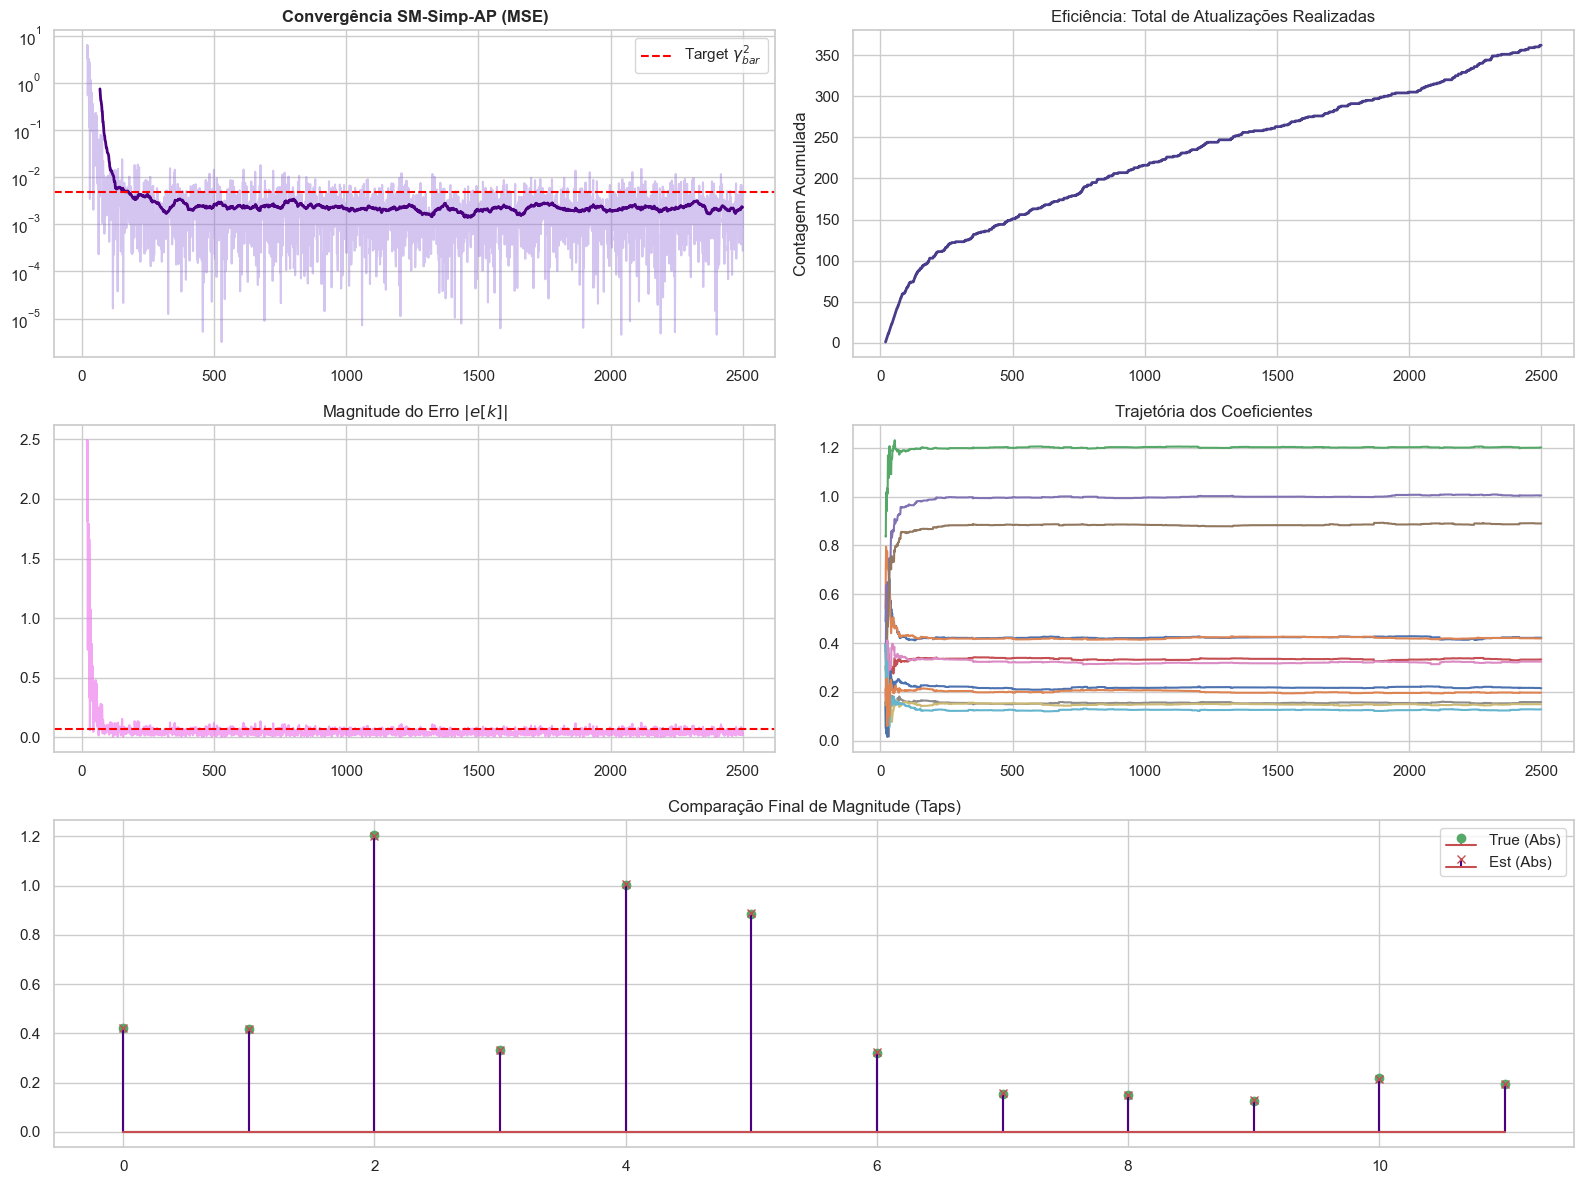

In [3]:
# --- 3. DASHBOARD DE DIAGNÓSTICO ---
def plot_simp_ap_dashboard(result, w_true, g_bar, offset=20):
    sns.set_theme(style="whitegrid")
    t = np.arange(len(result.mse()))[offset:]
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2)

    # A. MSE e Threshold
    ax1 = fig.add_subplot(gs[0, 0])
    mse = result.mse()[offset:]
    ax1.semilogy(t, mse, color='mediumpurple', alpha=0.4)
    ax1.semilogy(t, pd.Series(mse).rolling(50).mean(), color='indigo', lw=2)
    ax1.axhline(y=g_bar**2, color='red', linestyle='--', label=r'Target $\gamma_{bar}^2$')
    ax1.set_title("Convergência SM-Simp-AP (MSE)", fontweight='bold')
    ax1.legend()

    # B. Atividade de Update (Sparse Updates)
    ax2 = fig.add_subplot(gs[0, 1])
    mask = result.extra['update_mask'][offset:]
    ax2.plot(t, np.cumsum(mask), color='darkslateblue', lw=2)
    ax2.set_title("Eficiência: Total de Atualizações Realizadas")
    ax2.set_ylabel("Contagem Acumulada")

    # C. Magnitude do Erro Complexo
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(t, np.abs(result.errors)[offset:], color='violet', alpha=0.7)
    ax3.axhline(y=g_bar, color='red', ls='--')
    ax3.set_title("Magnitude do Erro $|e[k]|$")

    # D. Evolução dos Pesos (Magnitude)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(t, np.abs(result.coefficients[1:])[offset:])
    ax4.set_title("Trajetória dos Coeficientes")

    # E. Resposta ao Impulso: Real vs Estimado
    ax5 = fig.add_subplot(gs[2, :])
    w_f = result.coefficients[-1]
    ax5.stem(np.abs(w_true), linefmt='gray', markerfmt='go', label='True (Abs)')
    ax5.stem(np.abs(w_f), linefmt='indigo', markerfmt='rx', label='Est (Abs)')
    ax5.set_title("Comparação Final de Magnitude (Taps)")
    ax5.legend()

    plt.tight_layout()
    plt.show()

plot_simp_ap_dashboard(result, w_true, filt_simp_ap.gamma_bar)